In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

training_examples = 10000
testing_examples = 1000
sample_gap = 0.01
timesteps = 20

In [2]:
def generate_data(seq):
    x=[]
    y=[]
    
    for i in range(len(seq) - timesteps -1):
        x.append(seq[i:i+timesteps])
        y.append(seq[i+timesteps])
    return np.array(x, dtype = np.float32), np.array(y, dtype=np.float32)

In [3]:
test_start = training_examples*sample_gap
test_end = (test_start+testing_examples)*sample_gap

train_x, train_y = generate_data( np.sin(np.linspace(0, test_start, training_examples)))
test_x, test_y = generate_data( np.sin(np.linspace(test_start, test_end, testing_examples)))

In [4]:
lstm_size = 30
lstm_layers=2
batch_size = 64

x = tf.placeholder(tf.float32, [None, timesteps, 1], name='input_x')
y_ = tf.placeholder(tf.float32, [None, 1], name='input_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [5]:
# 有lstm_size个单元
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

# 添加dropout
drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = keep_prob)

# 一层不够，就多来几层
def lstm_cell():
    return tf.contrib.rnn.BasicLSTMCell(lstm_size)
cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(lstm_layers)])

# 进行forward，得到隐层的输出
outputs, final_state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
outputs = outputs[:,-1]

# 定义输出层, 输出值[-1,1]，因此激活函数用tanh
predictions = tf.contrib.layers.fully_connected(outputs, 1, activation_fn = tf.tanh)

cost = tf.losses.mean_squared_error(y_, predictions)

optimizer = tf.train.AdamOptimizer().minimize(cost)

In [6]:
def get_batches(x, y, batch_size = 64):
    for i in range(0, len(x), batch_size):
        begin_i = i
        end_i = i + batch_size if (i+batch_size)< len(x) else len(x)
        
        yield x[begin_i : end_i], y[begin_i : end_i]

In [ ]:
epochs = 20
session = tf.Session()
with session.as_default() as sess:
     # 初始化变量
    tf.global_variables_initializer().run()
    iteration = 1
    
    for e in range(epochs):
        for xs, ys in get_batches(train_x, train_y, batch_size):
            # xs[:, :, None] 增加一个维度，例如[64, 20] ==> [64, 20, 1]，为了对应输入
            feed_dict = {x:xs[:, :, None], y_:ys[:, None], keep_prob:.5}
            loss, _ = sess.run([cost, optimizer], feed_dict = feed_dict) 
            
            if iteration % 100 ==0:
                print('Epochs:{}/{}'.format(e, epochs),'Iteration:{}'.format(iteration),'Train loss:{:.8f}'.format(loss))
                iteration +=1
    

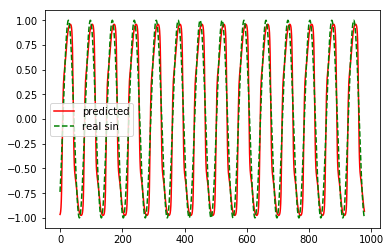

In [8]:
with session.as_default() as sess:
    feed_dict = {x:test_x[:, :, None], keep_prob:1.0}
    results = sess.run(predictions, feed_dict = feed_dict)
    plt.plot(results, 'r', label = 'predicted')
    plt.plot(test_y, 'g--', label = 'real sin')
    plt.legend()
    plt.show